# Exploratory Data Analysis

&lt; Work in progress &gt;

__TODO / MISSING__:
* Add hour of day to comments for further exploration
* Add day of week to comments
* Class distribution: use histograms instead of size()
* Scatter plots
* Violin plots


In [26]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv')
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

### First Look

In [2]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,19638181,19638181,1502197771,43,/schweiz/zuerich/story/19638181,Jetzt wird die Schwester der Europaallee gebaut,Gleisarena und Gleistribüne  so heissen die e...,Die neue Überbauung HB-Nord entsteht nördlich ...
1,31538566,31538566,1502083635,0,/schweiz/news/story/31538566,«Für mich ist eine Welt zusammengebrochen»,Beim Flugzeugunglück bei Pontresina starben dr...,Im Bündner Diavolezza-Gebiet ist ein Flugzeug ...
2,26200832,26200832,1502255246,6,/leben/reisen/story/26200832,Vollgas in die Entschleunigung,von Gabriella Hummel - Inside Vanlife: Nach 60...,Entschleunigung: Eine absolute Trendaktivität ...


In [3]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
0,13753138,1115_1225,0,21,1,ohne Partikelfilter,Heinz B.,am 05.08.2017 17:25,@Historiker: Aber im Gegensatz zu Baumaschine...
1,12645697,139_225,0,18,4,Jamie,Nene,am 29.07.2017 13:48,Foxx sieht doch nicht gut aus! Das ist ein Wi...
2,12645697,369_369,1,24,16,Ehefrau Amal,Mann43,am 29.07.2017 15:37,Ich muss schon sagen ich hätte auch gerne so ...


In [4]:
print(df_art.shape)
print(df_com.shape)

(707, 8)
(51572, 9)


In [5]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [6]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,707,707,707,707
mean,21104640,21079972,1502178471,74
std,6486614,6490320,76625,134
min,10003016,10003016,1502017728,0
25%,15582089,15567032,1502111914,0
50%,21154142,21140091,1502194750,22
75%,26713873,26713873,1502254962,79
max,31996579,31996579,1502256209,1171


In [7]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,51572,51572,51572,51572
mean,20926716,1,47,17
std,6374174,0,125,36
min,10003016,0,0,0
25%,15292283,0,7,2
50%,20123245,1,21,6
75%,26697746,1,46,17
max,31996579,1,3799,1072


In [8]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId             0
article_id      0
updated        -1
num_comments    4
dtype: float64


In [9]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    3
mob   -1
vup   13
vdo    8
dtype: float64


### Feature Engineering
To make further analysis possible concerning time features.

In [10]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['score'] = df_com['vup'] - df_com['vdo']

### Class Distribution

In [11]:
# 'df_art' has no classes

# 'df_com' 
print(df_com.groupby('mob').size())
print(df_com.groupby('hour').size())
print(df_com.groupby('weekday').size())

mob
0    16028
1    35544
dtype: int64
hour
0     1097
1      552
2      423
3      240
4      227
5      388
6     1645
7     2583
8     2730
9     2825
10    2944
11    3106
12    3651
13    3105
14    2767
15    2996
16    3292
17    3293
18    2610
19    2825
20    2289
21    1955
22    2106
23    1923
dtype: int64
weekday
0    5825
1    8998
2    6917
3    6758
4    6521
5    7738
6    8815
dtype: int64


### Correlation
Let's find relations between some of the attributes. Correlation requires continuous data.

In [12]:
# Only for these columns
cols = ['hour', 'weekday', 'weekday_fl', 'mob', 'vup', 'vdo']

# Change back how float is displayed
pd.options.display.float_format = '{:.4f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,hour,weekday,weekday_fl,mob,vup,vdo
hour,1.0000,0.0467,0.1581,0.0240,-0.0161,-0.0038
weekday,0.0467,1.0000,0.9937,0.0687,-0.0165,-0.0128
weekday_fl,0.1581,0.9937,1.0000,0.0706,-0.0181,-0.0131
mob,0.0240,0.0687,0.0706,1.0000,0.0686,0.0841
vup,-0.0161,-0.0165,-0.0181,0.0686,1.0000,0.3723
vdo,-0.0038,-0.0128,-0.0131,0.0841,0.3723,1.0000


### Scatter plot

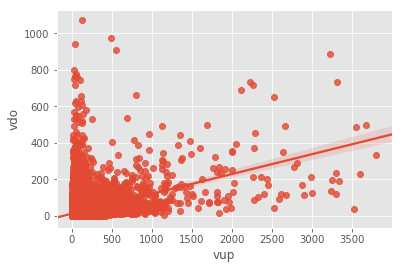

In [13]:
#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vup', y='vdo', data=df_com)
plt.show()

# Quite some outliers
# Are rows with upvotes of over 1000 real?
# Looked some of them up manually and yes, they have a lot of upvotes (3000+)

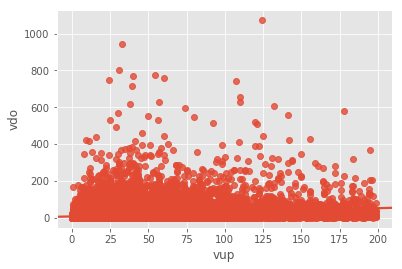

In [14]:
sns.regplot(x='vup', y='vdo', data=df_com[df_com['vup'] < 200])
plt.show()

### Prediction
Ok... I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to be most controversial (upvotes + downvotes)?
* Which articles go most score / were most controversial (sum over all comments)?

Impact will be taken into account from:
* Hour of comment
* Weekday
* Weekday + hour = Hour of week
* text written
* title written / if title is an answer (starts with "@")
* if from mobile (makes no sense, but let's see what happens)
* article text
* article category
* ...?

Problem:
* Some parts are computationally expensive / the ipython kernel has problems running it sometimes

In [27]:
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']
df_com['tit'] = df_com['tit'].str.lower()
#df_com['is_answer'] = df_com['tit']
df_com['con'] = df_com['con'].str.lower()
# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# is empty: (= all comments correspond to an article)
#print(df_merge[pd.isnull(df_merge['link'])])
#df_merge[df_merge['vup']>1000]

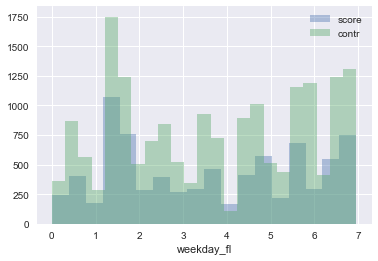

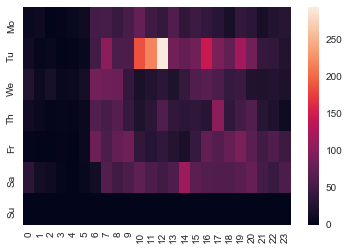

In [16]:
# Plot hist and heat map
sns.set(color_codes=True)
ax = sns.distplot(df_com[df_com['score']>50]['weekday_fl'], label='score', kde=False)
ax = sns.distplot(df_com[df_com['contr']>50]['weekday_fl'], label='contr', kde=False)
ax.legend()
plt.show()
grouped = df_com[df_com['score']>50].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting plays a big role
# This is probably because on certain days upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes
# - it may be possible, but we can't imply that (yet? / not enough data)

In [ ]:
# TODO make test set

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Prepare data for X and y
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# Preprocessor removes number
# TODO compile regex for better performance
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
vect = CountVectorizer(preprocessor=no_numbers, min_df=5, ngram_range=(1, 1), stop_words=stop_words) # Range higher than 1 doesn't help

def classify(val):
    if val > 100: return 1
    return 0

# TODO split this
# For comments
if False:
    X_train_counts = vect.fit_transform(df_merge['con'])
    y_train = df_merge['score'].apply(classify)
# For articles, some articles have no text
else:
    X_train_counts = vect.fit_transform(df_merge[pd.notnull(df_merge['text'])]['text'])
    y_train = df_merge[pd.notnull(df_merge['text'])]['score'].apply(classify)

#y_scaler = StandardScaler()
#y_train = y_scaler.fit_transform(df_merge['score'][:, None])
#y_test = y.scaler.transform(y_test)

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Get best parameter
if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'C': np.logspace(-3, 1, 5)}#, 'gamma': np.logspace(-2, 1, 4)}
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=3)
    grid.fit(X_train_counts, y_train)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: ", grid.best_params_)
# Just prepare data
else:
    print("Ok")
    
# Summary:
# Removing stop words didn't help the score (didn't add information), 
#   but it makes the model easier to interpret
# N-gram over 1 doesn't give a better score
# Threshold > 100 for classification gives a better prediction than for > 50, 
#   easier to classify because of ...
# Even a score of 0.86 is still bad because it's from cross validation

In [32]:
 # Run to understand how coefficients are set / which words are important
logreg = LogisticRegression(C=1e-2)
logreg.fit(X_train_counts, y_train)
coeff_by_name = {}
for i, f in enumerate(vect.get_feature_names()):
    coeff_by_name[f] = logreg.coef_[:, i][0]

coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)

for c in coeff_sorted[0:30]:
    print("{}\t{}".format(c[0], c[1]))
print("----------")
for c in coeff_sorted[-30:]:
    print("{}\t{}".format(c[0], c[1]))

# Summary comments:
# It seems that making positive comments about something bad that happened
#     gives a lot of upvotes
# Downvotes seem to be received for grumbling and arguing

# Summary articles:
# ~ Ranting about the 20min app etc. gives downvotes
# ~ Ranting about weapons, police, showing sympathy gives upvotes

anja	0.09518225912905734
NUM NUM	0.08026960488085114
polizei	0.07136900156483778
frauen	0.060713098808271034
eltern	0.05995033518463362
is	0.0591589033676526
da	0.058745098897920164
frau	0.05561670826694424
namdari	0.05351159086799471
kaum	0.05008912680389066
behörden	0.049202557081222155
gefahr	0.04881934708053927
NUM franken	0.04848509311896952
grenze	0.04747811237859901
whisky	0.04596636087571318
davon	0.04595522759488904
waffen	0.04589868116640529
viktor	0.045699073570975066
deutschland	0.044442799797921616
darauf	0.043654563006973804
job	0.04268550429844604
diesen	0.04197350867161
wollen	0.04168863856740144
gto	0.04135182144581698
wollte	0.03994331223435
ihrer	0.039927069483163054
angebote	0.03939086014069377
auftritt	0.039235370703981004
echt	0.03913445406558748
siemens	0.03905992826178616
----------
NUM0	-0.06652785517252774
bis	-0.06975193953279331
nag	-0.07029598109153176
fal	-0.07043171886445504
fal nag	-0.07233266780112568
gibts	-0.07265991216204133
lia	-0.07278263591780237


In [25]:
# Predict score for given comment text
